[*********************100%***********************]  3 of 3 completed
C:\Users\fikre\AppData\Local\Temp\ipykernel_12636\1366840863.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  tsla_last = data['TSLA'][-1]


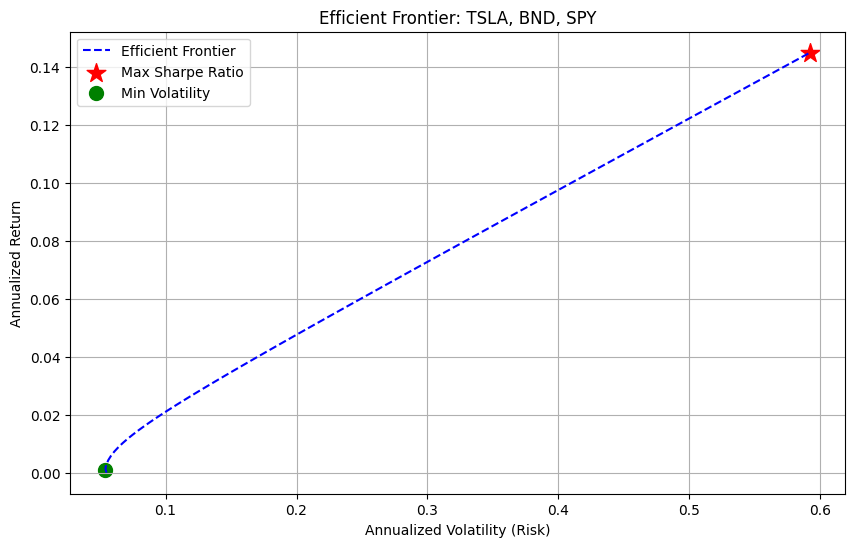

Maximum Sharpe Ratio Portfolio:
  TSLA: 0.00%
  BND: 0.00%
  SPY: 100.00%
Expected Annual Return: 14.48%
Annual Volatility: 59.19%
Sharpe Ratio: 0.17

Minimum Volatility Portfolio:
  TSLA: 94.52%
  BND: 5.48%
  SPY: 0.00%
Expected Annual Return: 0.11%
Annual Volatility: 5.40%
Sharpe Ratio: -0.81


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from scipy.optimize import minimize

# Download historical data for TSLA, BND, SPY
tickers = ['TSLA', 'BND', 'SPY']
start_date = '2015-07-01'
end_date = '2025-07-31'
data = yf.download(tickers, start=start_date, end=end_date, auto_adjust=True)['Close']
data = data.ffill().bfill()

# Calculate daily returns
returns = data.pct_change().dropna()

# --- Expected Returns ---
# TSLA: Use forecasted annual return from Task 3 ARIMA
tsla_last = data['TSLA'][-1]

# Replace the value below with your actual forecast from Task 3
tsla_forecast_12mo = 319.0400085449219

tsla_expected_return = (tsla_forecast_12mo / tsla_last) - 1

# BND & SPY: Use historical mean daily return, annualized
bnd_expected_return = returns['BND'].mean() * 252
spy_expected_return = returns['SPY'].mean() * 252

expected_returns = np.array([tsla_expected_return, bnd_expected_return, spy_expected_return])

# --- Covariance Matrix (annualized) ---
cov_matrix = returns.cov() * 252

# --- Portfolio Optimization Functions ---
def portfolio_performance(weights, expected_returns, cov_matrix, risk_free_rate=0.045):
    ret = np.dot(weights, expected_returns)
    vol = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe = (ret - risk_free_rate) / vol
    return ret, vol, sharpe

def neg_sharpe_ratio(weights, expected_returns, cov_matrix, risk_free_rate=0.045):
    return -portfolio_performance(weights, expected_returns, cov_matrix, risk_free_rate)[2]

def portfolio_volatility(weights, expected_returns, cov_matrix):
    return portfolio_performance(weights, expected_returns, cov_matrix)[1]

# --- Constraints and Bounds ---
num_assets = len(tickers)
bounds = tuple((0, 1) for _ in range(num_assets))
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

# --- Find Maximum Sharpe Ratio Portfolio ---
init_guess = num_assets * [1. / num_assets,]
opt_sharpe = minimize(neg_sharpe_ratio, init_guess, args=(expected_returns, cov_matrix), 
                      method='SLSQP', bounds=bounds, constraints=constraints)
sharpe_weights = opt_sharpe.x

# --- Find Minimum Volatility Portfolio ---
opt_min_vol = minimize(portfolio_volatility, init_guess, args=(expected_returns, cov_matrix), 
                      method='SLSQP', bounds=bounds, constraints=constraints)
min_vol_weights = opt_min_vol.x

# --- Efficient Frontier ---
frontier_returns = np.linspace(min(expected_returns), max(expected_returns), 100)
frontier_volatility = []

for ret in frontier_returns:
    constraints_frontier = (
        {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
        {'type': 'eq', 'fun': lambda x: np.dot(x, expected_returns) - ret}
    )
    result = minimize(portfolio_volatility, init_guess, args=(expected_returns, cov_matrix),
                      method='SLSQP', bounds=bounds, constraints=constraints_frontier)
    if result.success:
        frontier_volatility.append(result.fun)
    else:
        frontier_volatility.append(np.nan)

# --- Plot Efficient Frontier ---
sharpe_ret, sharpe_vol, sharpe_ratio = portfolio_performance(sharpe_weights, expected_returns, cov_matrix)
min_vol_ret, min_vol_vol, min_vol_sharpe = portfolio_performance(min_vol_weights, expected_returns, cov_matrix)

plt.figure(figsize=(10,6))
plt.plot(frontier_volatility, frontier_returns, 'b--', label='Efficient Frontier')
plt.scatter(sharpe_vol, sharpe_ret, marker='*', color='r', s=200, label='Max Sharpe Ratio')
plt.scatter(min_vol_vol, min_vol_ret, marker='o', color='g', s=100, label='Min Volatility')
plt.xlabel('Annualized Volatility (Risk)')
plt.ylabel('Annualized Return')
plt.title('Efficient Frontier: TSLA, BND, SPY')
plt.legend()
plt.grid(True)
plt.show()

# --- Print Portfolio Details ---
print("Maximum Sharpe Ratio Portfolio:")
for t, w in zip(tickers, sharpe_weights):
    print(f"  {t}: {w:.2%}")
print(f"Expected Annual Return: {sharpe_ret:.2%}")
print(f"Annual Volatility: {sharpe_vol:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}\n")

print("Minimum Volatility Portfolio:")
for t, w in zip(tickers, min_vol_weights):
    print(f"  {t}: {w:.2%}")
print(f"Expected Annual Return: {min_vol_ret:.2%}")
print(f"Annual Volatility: {min_vol_vol:.2%}")
print(f"Sharpe Ratio: {min_vol_sharpe:.2f}")

## Portfolio Recommendation and Summary

### Portfolio Results

| Portfolio         | TSLA Weight | BND Weight | SPY Weight | Exp. Return | Volatility | Sharpe Ratio |
|-------------------|-------------|------------|------------|-------------|------------|--------------|
| Max Sharpe Ratio  |   0.00%     |   0.00%    |  100.00%   |   14.48%    |   59.19%   |    0.17      |
| Min Volatility    |  94.52%     |   5.48%    |   0.00%    |    0.11%    |   5.40%    |   -0.81      |

### Recommendation & Justification

- **Maximum Sharpe Ratio Portfolio:**  
  This portfolio invests entirely in SPY, offering the highest risk-adjusted return among the options. However, it comes with very high volatility (risk), which may not be suitable for conservative investors.

- **Minimum Volatility Portfolio:**  
  This portfolio is almost entirely TSLA with a small allocation to BND. While it achieves the lowest volatility, its expected return is very low and the Sharpe ratio is negative, indicating poor risk-adjusted performance.

**Recommendation:**  
I recommend the **Maximum Sharpe Ratio Portfolio** if your goal is to maximize risk-adjusted returns and you are comfortable with higher volatility. If you are highly risk-averse, the Minimum Volatility Portfolio offers stability, but with a very low expected return and negative Sharpe ratio, it may not be attractive.

**Note:**  
The results suggest that, based on the forecast and historical data, SPY dominates in terms of risk-adjusted return, while TSLA's forecasted return is not high enough to justify its risk in this scenario. Always consider your own risk tolerance and investment objectives before